In [1]:
import pathlib
import os

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
date = "12_16_2022"
fly = "EPG_GCaMP7f_CsChrimsontdT_fly1"
session = "random_remapping-004"
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'])
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)

In [3]:
f = h5py.File(h5name)
data = f['/data'][:]



In [4]:
ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)


In [5]:
shifts.shape

(2, 3280, 7)

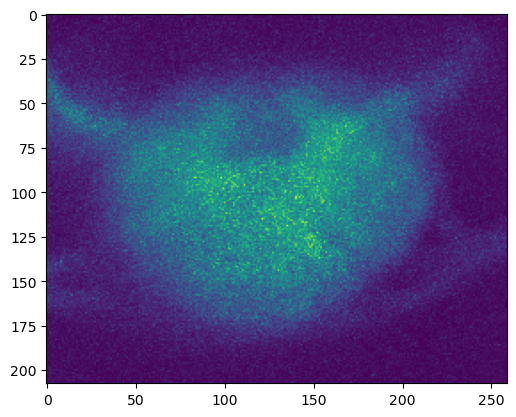

In [6]:
fig, ax = plt.subplots()
ax.imshow(ref_img[0,:,:,:].max(axis=0))

In [8]:
ref_img_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/ref_img.npy'
np.save(ref_img_file, ref_img)


In [25]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession().new_session(ref_img)

In [8]:
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{fly}/{session}/napari.pkl'

In [9]:
import cloudpickle
with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks = np_layers['rois']

In [9]:

eb_napari.make_phase_masks()
masks = eb_napari.masks

In [10]:

eb_napari.save_layers(napari_outputs_file)

In [ ]:
eb_napari = st2p.preprocessing.napari_tools.EllipsoidBodySession()
eb_napari.open_existing_session(napari_outputs_file)
# eb_napari.make_phase_masks()


In [10]:
from glob import glob
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

In [11]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [12]:
df_aligned.head()

,Time(ms),start_trigger,opto_trigger,fictrac_cam_exp,fictrac_frame_proc,heading,index,arena_heading,arena_index,heading_cartx,heading_carty,index_cartx,index_carty,arena_heading_cartx,arena_heading_carty,arena_index_cartx,arena_index_carty
0,54.892588,1.0,0.0,26.0,26.0,0.017591,0.007741,2.353659,-3.082698,0.999845,0.017590,0.999970,0.007741,-0.705311,0.708897,-0.998266,-0.058861
1,164.677764,0.0,0.0,52.0,52.0,0.011443,0.007500,-3.077275,-3.081493,0.999934,0.011443,0.999972,0.007500,-0.997931,-0.064273,-0.998194,-0.060063
2,274.462940,0.0,0.0,51.0,52.0,-0.029016,0.006655,-0.000682,-3.084869,0.999579,-0.029012,0.999978,0.006655,1.000000,-0.000682,-0.998390,-0.056693
3,384.248116,0.0,0.0,52.0,51.0,-0.036838,0.007161,-0.525211,-3.083579,0.999320,-0.036829,0.999974,0.007161,0.865217,-0.501394,-0.998315,-0.057981
4,494.033292,0.0,0.0,52.0,52.0,-0.887933,0.001402,1.961827,-3.082476,0.630795,-0.775496,0.999999,0.001402,-0.381141,0.924516,-0.998252,-0.059082


In [13]:
F = st2p.preprocessing.signals.extract_2p_timeseries(data, masks, 16) + 1E-3

In [14]:
# baseline
F_base = np.copy(F)
# smooth with a 1s gaussian
F_base = sp.ndimage.gaussian_filter1d(F_base,100,axis=-1)
F_base = np.percentile(F_base,5,axis=-1, keepdims=True)
# 10 s min max
# F_base = sp.ndimage.minimum_filter1d(F_base, 300, axis=-1)
# F_base = sp.ndimage.maximum_filter1d(F_base, 300, axis=-1)

In [15]:
F = sp.ndimage.gaussian_filter1d(F,1,axis=-1)
# denom = F[0,:,:].mean(axis=1, keepdims=True).sum(axis=0,keepdims=True)
# f_denom = F[0,:,:].mean(axis=1,keepdims=True)/denom
dff = F[1,:,:]/F_base[1,:,:]
# dff = sp.stats.zscore(dff,axis=-1)
# dff = 0*F[1,:,:]
# dff = sp.stats.zscore(F[1,:,:],axis=-1)


In [16]:
print(np.amin(dff),np.amax(dff))

0.00010253504214114942 3.361507070969456


In [17]:

x,y = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x.mean(axis=0), y.mean(axis=0))

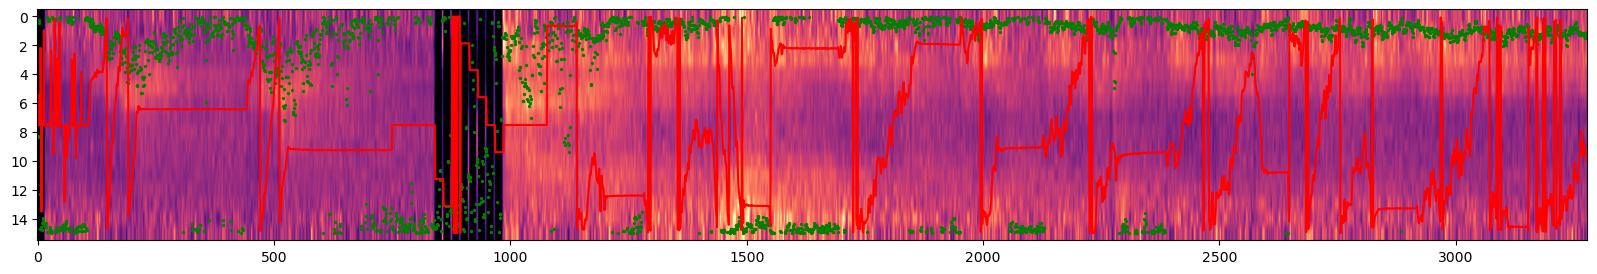

In [18]:
win_size = 4000
for start_i in range(0,dff.shape[-1],win_size):
    stop_i = min(start_i+win_size, dff.shape[-1]-1)
    window = slice(start_i, stop_i)
    fig, ax = plt.subplots(figsize=[20,3])
    dff_window = dff[:,window]
    ax.imshow(dff_window,aspect='auto',cmap='magma',vmin=0,vmax=3)
    x = np.arange(stop_i-start_i)
    ax.plot(x,15*(df_aligned['heading'].iloc[window].to_numpy()+np.pi)/2/np.pi,color='red')
    
    ax.scatter(x,15*(phi[window]+np.pi)/2/np.pi,color='green', s=2)


In [19]:
offset = (phi-df_aligned['heading'])


In [20]:
_, offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(offset.shape),offset))

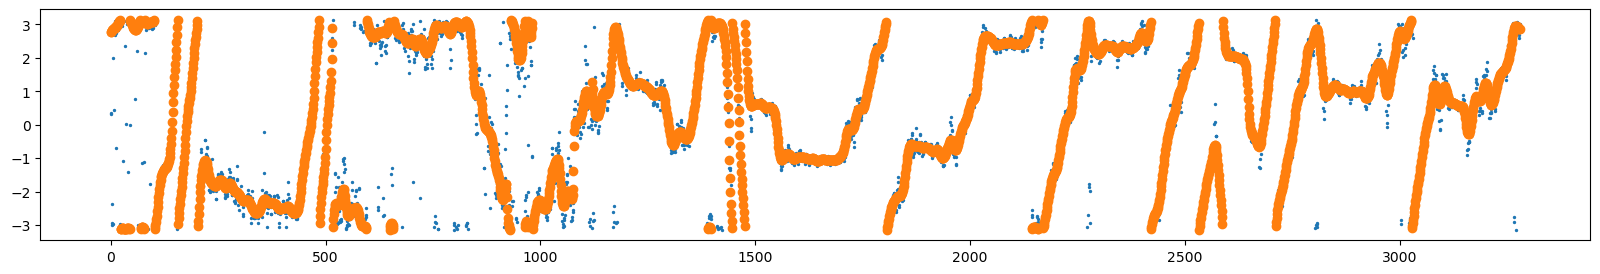

In [21]:
fig,ax = plt.subplots(figsize=[20,3])
ax.scatter(np.arange(offset.shape[0]),offset,s=2)
offset_cart_x, offset_cart_y = st2p.utilities.pol2cart(np.ones(offset.shape),offset)
_, offset_sm = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(offset_cart_x,5),sp.ndimage.gaussian_filter1d(offset_cart_y,5))
ax.scatter(np.arange(offset.shape[0]), offset_sm)

(array([192., 208., 176., 116., 131., 261., 173., 141., 167., 248., 238.,
        190., 159., 261., 320., 299.]),
 array([-3.14156098e+00, -2.74888435e+00, -2.35620773e+00, -1.96353110e+00,
        -1.57085447e+00, -1.17817785e+00, -7.85501220e-01, -3.92824593e-01,
        -1.47966103e-04,  3.92528661e-01,  7.85205288e-01,  1.17788191e+00,
         1.57055854e+00,  1.96323517e+00,  2.35591180e+00,  2.74858842e+00,
         3.14126505e+00]),
 <BarContainer object of 16 artists>)

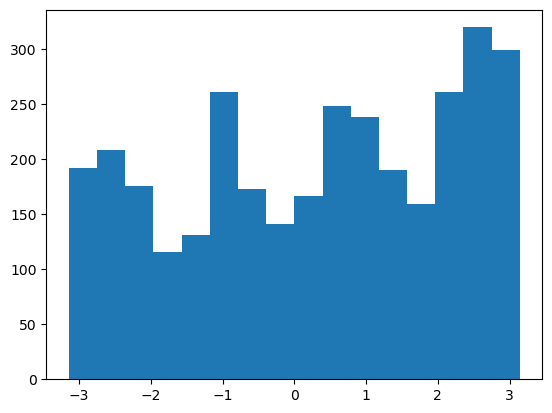

In [22]:
fig, ax = plt.subplots()
ax.hist(offset,bins=16)

In [11]:
data.shape

(2, 3280, 7, 208, 259)